# GSM

- 900MHz range composed of channels 0-124 with 200kHz spacing<br>
- modulation: 0.3GMSK (Gaussian minimum shift keying (frequency modulation)<br>
- frequency difference (for MSK): $\Delta f = 1/(2 \Delta t) = 135.416kHz $ ($\pm 67.708kHz$ around center frequency)<br>
- bitrate: 270.833kbit/s<br>

### Resources
http://www.cs.ru.nl/~fabianbr/pub/scriptie.pdf<br>

### frequencies

E-GSM-900:-----up:880.0–915.0-------down:925.0–960.0------ch:0-124<br>
R-GSM-900:-----up:876.0–915.0-------down:921.0–960.0------ch:0-124<br>
DCS-1800:------up:1710.2–1784.8-----down:1805.2–1879.8-----ch:512-885<br>

### GSMK Modulation
from: Digital cellular telecommunications system (Phase 2+);Modulation(GSM 05.04 version 8.1.2 Release 1999) [ETSI EN 300 959]

differential encoding of two bits at a time:
\begin{align}
\hat{d}_i = (d_{i-1}+d_{i}) \mod 2
\end{align}

modulation data:
\begin{align}
\alpha_i = 1 - 2\hat{d}_i \in \{-1,1\}
\end{align}

impulse response of filter:
\begin{align}
g(t) = rect\Big(\frac{1}{T}\Big) \circledast \frac{\exp\Big(\frac{-t^2}{2\delta^2T^2}\Big)}{\sqrt{2 \pi} \cdot \delta T}
\end{align}
with $\delta = \frac{\sqrt{\ln(2)}}{2\pi B T}$, where B is the 3dB bandwidth and T the time duration of one bit ($BT=0.3$)

output phase:
\begin{align}
\phi(t) = \int_{t_0}^{t} \underbrace{\sum_i \alpha_i}_{\text{signal}} \cdot \frac{\pi}{2} \cdot \underbrace{g(u)}_{\text{impulse response}} du
\end{align}
where the current index i is dependent on time.

modulation:
\begin{align}
x(t) = \sqrt{\frac{2 E}{T}}\cos(2\pi f_0 t + \phi(t) + \phi_0)
\end{align}

### burst

Within a channel data is send in TDMA frames. A TDMA frame contains 8 burst wich are assigned to different mobile phones (time multiplexing).<br>
Uplink lags by 3 time slots (bursts) to the downlink and they are seperated by exactly 45mhz.<br>

<img src="gsm_burst.png" style="width:500px">

- 1 burst (576.9us)
- 8 bursts = TDMA frame (4.615ms)
- 26 TDMAs = traffic multiframe (120ms)
- 51 traffic multiframes = traffic superframe (6.12s)
- 51 TDMAs = control multiframe (235.4ms)
- 26 control multiframes = control superframe (6.12s)
- 2048 superframes = hyperframe (12533.76s)



### channels

<b style="font-size:15px">cch control channels (call setup, power adjustment)</b><br>
<b style="font-size:15px">tch traffic channels (voice, data)</b><br>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

global pi,i
pi =np.pi
i = np.complex(0,1)

N = 20 #data symbols
bps = 156.25/576.9e-6 #bits per second
n = 1000 #data samples
dT = T/n #time step between samples
numN = n/N #samples per symbol
t = np.arange(0,T,dT)

data = np.zeros(n)
d = np.round(np.random.rand(N))
for ii in range(N):
    if d[ii]==1:
        data[int(ii*numN):int((ii+1)*numN)] = 1

f_c = 4
carrier = np.sin(2*pi*f_c*t)
ask_signal = carrier * (0.75*data+0.25) #amplitude modulation
psk_signal = np.sin(2*pi*f_c*t + pi*data) #phase modulation
fsk_signal = np.sin(2*pi*(f_c+2*(data-0.5))*t) #frequency modulation

fig = plt.figure(figsize=(18,15))

plt.subplot(5,1,1)
plt.title('binary data')
plt.plot(t,data)

plt.subplot(5,1,2)
plt.title('carier')
plt.plot(t,carrier)

plt.subplot(5,1,3)
plt.title('amplitude-shift keying (ASK)')
plt.plot(t,ask_signal)

plt.subplot(5,1,4)
plt.title('Phase-shift keying (PSK)')
plt.plot(t,psk_signal)

plt.subplot(5,1,5)
plt.title('Frequency-shift keying (FSK)')
plt.plot(t,fsk_signal)

plt.show()

## py rtl sdr documentation
https://pyrtlsdr.readthedocs.io/en/latest/rtlsdr.html

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import decimate
from rtlsdr import RtlSdr

In [144]:
# configure device & capture data
freq = 935.2e+6
sample_rate = 2280000
bandwidth = 200e+3
nr_samples = 2**18
time_interval = nr_samples/sample_rate

sdr = RtlSdr()
sdr.sample_rate = sample_rate
sdr.center_freq = freq
sdr.bandwidth = bandwidth
sdr.freq_correction = 60 #PPM
sdr.gain = 'auto'
samples = sdr.read_samples(nr_samples)
sdr.close()

In [2]:
# power spectral density (sum of windowed fft)
from pylab import psd
psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
plt.title('power spectral density')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
plt.show()

NameError: name 'samples' is not defined

Text(0, 0.5, 'amplitude')

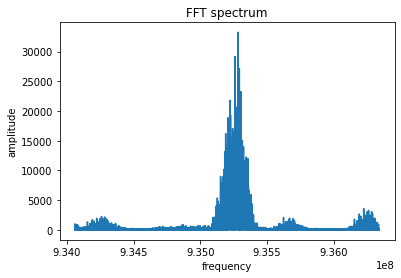

In [147]:
### simple fft spectrum
fig = plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
frequencies = (np.arange(-nr_samples/2,nr_samples/2,1))*1/time_interval
plt.plot(freq + frequencies,abs(spectrum))
plt.title('FFT spectrum')
plt.xlabel('frequency')
plt.ylabel('amplitude')

In [165]:
burst_time = 576.9e-6 #burst time
burst_symbols = 156.25 #bits per burst
bps = burst_symbols/burst_time #bits per second
sample_per_burst = sample_rate*burst_time
print('bits per second: ',bps)
print('time per bit/symbol: ',1/bsp)
print('samples captured per burst:',sample_per_burst)

bits per second:  270844.16710001737
samples captured per burst: 1315.3319999999999


In [157]:
c = 21045

Text(0, 0.5, 'amplitude')

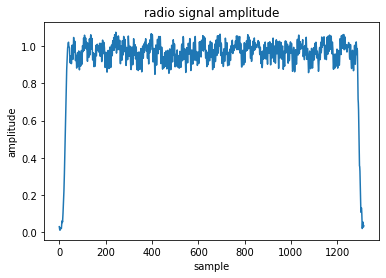

In [158]:
plt.plot(np.abs(samples[c:int(sample_per_burst)+c]))
plt.title('radio signal amplitude')
plt.xlabel('sample')
plt.ylabel('amplitude')

Text(0, 0.5, 'phase')

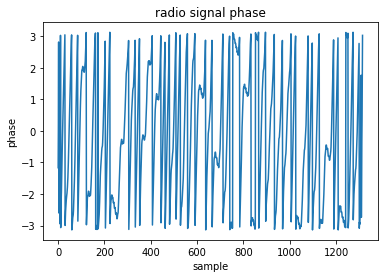

In [159]:
plt.plot(np.angle(samples[c:int(sample_per_burst)+c]))
plt.title('radio signal phase')
plt.xlabel('sample')
plt.ylabel('phase')

Text(0, 0.5, 'phase')

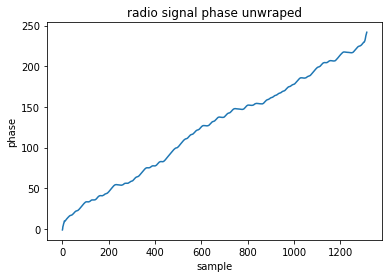

In [160]:
plt.plot(np.unwrap(np.angle(samples[c:int(sample_per_burst)+c])))
plt.title('radio signal phase unwraped')
plt.xlabel('sample')
plt.ylabel('phase')

In [1]:
plt.plot(np.diff(np.unwrap(np.angle(samples[c:int(sample_per_burst)+c])),1))
plt.title('sound = radio signal phase difference')
plt.xlabel('sample')
plt.ylabel('phase change')

NameError: name 'plt' is not defined

In [ ]:
#multithreading
import threading
t = threading.Thread(name='name', target=function)
t.start()
t.join()